# 🎓 Capstone Project - Advanced Machine Learning
## TEC-VIII Programa de Especialización en Big Data Analytics aplicada a los Negocios

---

### 📋 Información del Proyecto

| Campo | Información |
|-------|-------------|
| **Nombre del Estudiante** | Roxana Elizabeth Lozano Mallqui |
| **Título del Proyecto** | Sistema de Detección de Vehículos de Acompañamiento Sospechoso |
| **Fecha de Entrega** | 18/02/2026 |
| **Profesor** | Carlos |

---

## 📑 Índice

1. [Resumen Ejecutivo](#1-resumen-ejecutivo)
2. [Configuración del Entorno](#2-configuración-del-entorno)
3. [Definición del Problema de Negocio](#3-definición-del-problema-de-negocio)
4. [Carga y Exploración de Datos](#4-carga-y-exploración-de-datos)
5. [Preprocesamiento de Datos](#5-preprocesamiento-de-datos)
6. [Diseño y Arquitectura del Modelo](#6-diseño-y-arquitectura-del-modelo)
7. [Entrenamiento del Modelo](#7-entrenamiento-del-modelo)
8. [Evaluación y Métricas](#8-evaluación-y-métricas)
9. [Interpretación de Resultados](#9-interpretación-de-resultados)
10. [Conclusiones y Recomendaciones de Negocio](#10-conclusiones-y-recomendaciones-de-negocio)
11. [Referencias](#11-referencias)

---
## 1. Resumen Ejecutivo

**Instrucciones:** Proporcione un resumen conciso (máximo 300 palabras) que incluya:
- Problema de negocio abordado
- Metodología utilizada
- Principales hallazgos
- Impacto esperado en el negocio

---
**Problema de negocio abordado:** La empresa cuenta con áreas que evalúan diferentes riesgos, el detallar los criterios o modalidades no está permitido, por lo que el problema se describirá de manera general. Se han identificado vehículos que operan como acompañantes de vehículos con alguna incidencia, estos son llamados liebres, que circulan próximos en espacio y tiempo. Se busca evaluar la información de peajes a nivel nacional para identificar que vehículos actúan como acompañantes y poder anticipar determinadas acciones.

**Metodología utilizada:** Se emplearon 6 etapas.

1.   Carga de datos (Datos sinteticos)
2.   Exploración de Datos (EDA).
3.   Feature Engineering.
4.   Generación de Embeddings(autoencoder).
5.   Deteccion y agrupamiento (Clustering).
6.   Modelo predictivo con explicabilidad (SHAP).

**Principales Hallazgos**: Pendiente.. *

**Impacto esperado del negocio:** Identificación de liebres para generar alertar en los puestos de control.

---

## 2. Configuración del Entorno

### 2.1 Verificación de GPU (Recomendado para Deep Learning)

In [1]:
# Verificar si hay GPU disponible
import torch

# Verificar disponibilidad de GPU
if torch.cuda.is_available():
    print(f"✅ GPU disponible: {torch.cuda.get_device_name(0)}")
    print(f"   Memoria GPU: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    device = torch.device('cuda')
else:
    print("⚠️ GPU no disponible. Usando CPU.")
    print("   Recomendación: En Colab, vaya a Runtime > Change runtime type > GPU")
    device = torch.device('cpu')

print(f"\nDispositivo seleccionado: {device}")

✅ GPU disponible: Tesla T4
   Memoria GPU: 15.64 GB

Dispositivo seleccionado: cuda


### 2.2 Instalación de Librerías Adicionales (si es necesario)

In [ ]:
# Descomente e instale las librerías adicionales que necesite
# !pip install transformers
# !pip install pytorch-lightning
# !pip install optuna
# !pip install shap
# !pip install lime

### 2.3 Importación de Librerías

In [2]:
# =====================================================
# LIBRERÍAS FUNDAMENTALES
# =====================================================

# Manipulación de datos
import numpy as np
import pandas as pd

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning - PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset

# Deep Learning - TensorFlow/Keras (alternativa)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks

# Preprocesamiento
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report,
                             mean_squared_error, mean_absolute_error, r2_score)

# Utilidades
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
%matplotlib inline

# Semilla para reproducibilidad
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

print("✅ Todas las librerías importadas correctamente")
print(f"   PyTorch version: {torch.__version__}")
print(f"   TensorFlow version: {tf.__version__}")

✅ Todas las librerías importadas correctamente
   PyTorch version: 2.9.0+cu128
   TensorFlow version: 2.19.0


### 2.4 Conexión con Google Drive (para cargar datos)

In [3]:
# Montar Google Drive para acceder a los datos
from google.colab import drive
drive.mount('/content/drive')

# Definir la ruta base de su proyecto
# Modifique esta ruta según la ubicación de sus datos
BASE_PATH = '/content/drive/MyDrive/TAF_AML/'

print(f"✅ Google Drive montado")
print(f"   Ruta base del proyecto: {BASE_PATH}")

Mounted at /content/drive
✅ Google Drive montado
   Ruta base del proyecto: /content/drive/MyDrive/TAF_AML/


---
## 3. Definición del Problema de Negocio

### 3.1 Contexto del Negocio

**Instrucciones:** Describa el contexto empresarial, incluyendo:
- Industria/Sector
- Empresa o caso de estudio
- Situación actual

---

*Industria/Sector: Control y fiscalización de tránsito vehicular a nivel nacional.*

*Empresa o caso de estudio: Entidad del estado.*

*Situación actual: Actualmente en los puestos de control se identifican vehiculos con incidencias, sin embargo se ha visto que hay vehiculos que operan como acompañantes que circulan proximos a estos vehiculos. Actualmente no se toman acciones preventivas respecto a estos vehiculos acompañantes*

---

### 3.2 Problema a Resolver

**Instrucciones:** Defina claramente:
- ¿Cuál es el problema específico?
- ¿Por qué es importante resolverlo?
- ¿Cuál es el impacto actual del problema?

---

- ¿Cuál es el problema específico? Identificar automáticamente qué vehículos actúan como acompañantes ("liebres") de vehículos con incidencia confirmada, a partir del análisis masivo de registros de peaje que contienen: placa vehicular, fecha hora y ubicación del peaje.

- ¿Por qué es importante resolverlo? Identificar liebres permite generar alertas preventivas antes de que ocurran incidencias, no solo reaccionar cuando ya sucedieron

- ¿Cuál es el impacto actual del problema?

Actualmente solo se generan 1 o 2 acciones preventivas al mes. Se espera generar al menos una accion por semana.

---

### 3.3 Objetivos del Proyecto

**Instrucciones:** Liste los objetivos SMART (Específicos, Medibles, Alcanzables, Relevantes, Temporales)

---

**Objetivo General:**
Desarrollar e implementar un sistema de Machine Learning que identifique automáticamente vehículos con patrones de acompañamiento a vehículos de interés con incidencia, alcanzando una precisión mínima del 80%.

**Objetivos Específicos:**
1. Entrenar un modelo predictivo capaz de asignar scores de riesgo (probabilidad de ser liebre) a cada vehículo, con explicación mediante SHAP
2. Implementar un sistema de alertas en tiempo real que notifique a los puestos de control cuando transite un vehículo identificado como liebre, habilitando inspección de vehículos dentro de un lapso de 30 minutos o lo que determine la gerencia.

---

### 3.4 Tipo de Problema de Machine Learning

**Instrucciones:** Identifique el tipo de problema:
- [x] x - Clasificación binaria
- [ ] Clasificación multiclase
- [ ] Regresión
- [x] x - Clustering
- [ ] Series temporales
- [ ] Procesamiento de Lenguaje Natural (NLP)
- [ ] Visión por Computadora
- [ ] Otro: _________

**Justificación:**
El modelo aprende de los casos que ya conocidosa partir de los vehículos con incidencia (VI). Entonces se entra un modelo clasificador que aprende "qué características tienen los vehículos que acompañan a los VI" y luego predice qué otros vehículos tienen esas mismas características. La varaible objetivo es 1 o 0.
Luego se emplea la clusterizacion para identificar que vehiculos se comportan de manera similar a los VI, donde se espera identificar grupos u horarios con posible riesgo de incidencia.

---

---
## 4. Carga y Exploración de Datos

### 4.1 Carga de Datos

In [103]:
# =====================================================
# CARGA DE DATOS
# =====================================================

 #Opción 1: Cargar desde Google Drive
 #df = pd.read_csv(BASE_PATH + 'registros_peaje_sintetico.csv')

# Opción 2: Cargar desde URL
# df = pd.read_csv('https://url-de-sus-datos.com/datos.csv')

# Opción 3: Cargar desde archivo local (subido a Colab)
# from google.colab import files
# uploaded = files.upload()
# df = pd.read_csv('nombre_archivo.csv')

# Opción 4: Dataset de ejemplo (para testing)
# from sklearn.datasets import load_iris, load_boston, fetch_california_housing
# data = load_iris()
# df = pd.DataFrame(data.data, columns=data.feature_names)
# df['target'] = data.target

# =====================================================
# COMPLETE AQUÍ: Cargue su dataset
# =====================================================

df = pd.read_csv(BASE_PATH + 'registros_peaje_sintetico.csv')  # Descomente y complete

print(f"✅ Dataset cargado exitosamente")
print(f"   Dimensiones: {df.shape[0]:,} filas × {df.shape[1]} columnas")

✅ Dataset cargado exitosamente
   Dimensiones: 5,284 filas × 4 columnas


### 4.2 Descripción del Dataset

**Instrucciones:** Describa su dataset:
- Fuente de los datos: Información de peajes a nivel nacional
- Período de tiempo que cubren: primer semestre del 2024
- Descripción de cada variable

---

| Variable | Tipo | Descripción |
|----------|------|-------------|
| placa | categórica | [Placa de los vehiculos] |
| timestamp | timestamp| [Fecha y hora del paso por el peaje] |
| peaje_id | categórica |[Id del peaje] |
| es_vi | numérica| [Variable objetivo] |

---

### 4.3 Exploración Inicial de Datos (EDA)

In [90]:
# =====================================================
# INFORMACIÓN GENERAL DEL DATASET
# =====================================================

print("=" * 60)
print("INFORMACIÓN GENERAL DEL DATASET")
print("=" * 60)

# Primeras filas
print("\n📊 Primeras 5 filas:")
display(df.head())

# Información del dataset
print("\n📋 Información del Dataset:")
print(df.info())

# Estadísticas descriptivas
print("\n📈 Estadísticas Descriptivas:")
display(df.describe())

INFORMACIÓN GENERAL DEL DATASET

📊 Primeras 5 filas:


,placa,timestamp,peaje_id,es_vi
0,HDC-219,2024-01-01 00:15:17,P04,0
1,HDC-219,2024-01-01 01:08:17,P05,0
2,KGJ-687,2024-01-01 01:37:27,P03,0
3,YBK-845,2024-01-01 01:41:10,P03,0
4,HDC-219,2024-01-01 01:43:17,P06,0



📋 Información del Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5284 entries, 0 to 5283
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   placa      5284 non-null   object
 1   timestamp  5284 non-null   object
 2   peaje_id   5284 non-null   object
 3   es_vi      5284 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 165.3+ KB
None

📈 Estadísticas Descriptivas:


,es_vi
count,5284.000000
mean,0.063399
std,0.243702
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [91]:
# =====================================================
# ANÁLISIS DE VALORES FALTANTES
# =====================================================

print("=" * 60)
print("ANÁLISIS DE VALORES FALTANTES")
print("=" * 60)

# Calcular valores faltantes
missing_data = pd.DataFrame({
    'Total Faltantes': df.isnull().sum(),
    'Porcentaje (%)': (df.isnull().sum() / len(df) * 100).round(2)
})
missing_data = missing_data[missing_data['Total Faltantes'] > 0].sort_values('Porcentaje (%)', ascending=False)

if len(missing_data) > 0:
    print("\n⚠️ Variables con valores faltantes:")
    display(missing_data)

    # Visualización de valores faltantes
    plt.figure(figsize=(10, 6))
    sns.barplot(x=missing_data.index, y='Porcentaje (%)', data=missing_data)
    plt.title('Porcentaje de Valores Faltantes por Variable')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Porcentaje (%)')
    plt.tight_layout()
    plt.show()
else:
    print("\n✅ No hay valores faltantes en el dataset")

ANÁLISIS DE VALORES FALTANTES

✅ No hay valores faltantes en el dataset


ANÁLISIS DE LA VARIABLE OBJETIVO: es_vi

📊 Distribución de clases:
es_vi
0    4949
1     335
Name: count, dtype: int64


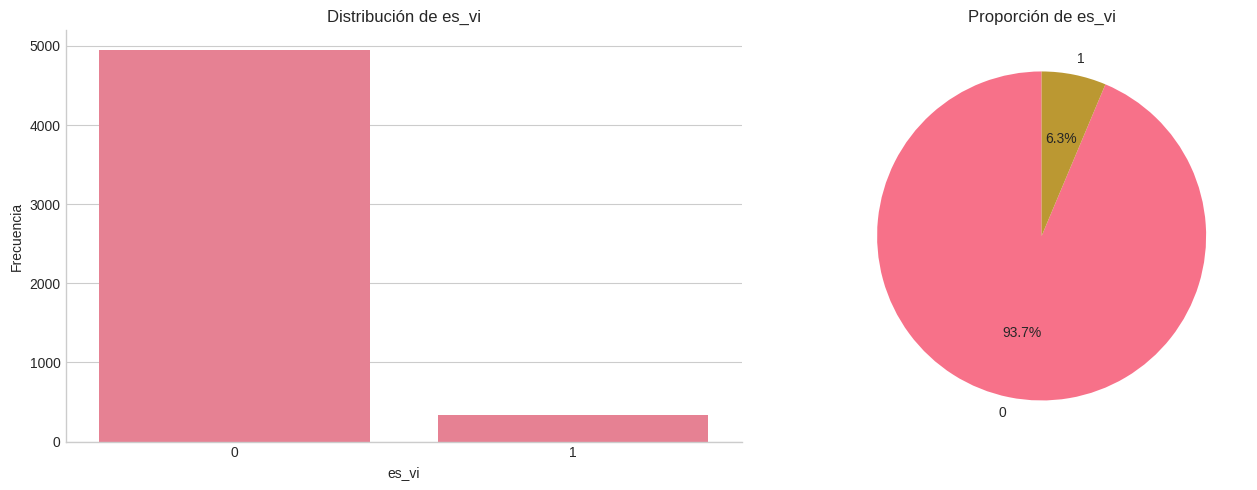


⚠️ ADVERTENCIA: Dataset desbalanceado (ratio 14.77:1)
   Considere técnicas de balanceo: SMOTE, undersampling, class weights


In [92]:
# =====================================================
# ANÁLISIS DE LA VARIABLE OBJETIVO
# =====================================================

# COMPLETE: Especifique el nombre de su variable objetivo
TARGET_COLUMN = 'es_vi'  # Cambie 'target' por el nombre de su variable objetivo

print("=" * 60)
print(f"ANÁLISIS DE LA VARIABLE OBJETIVO: {TARGET_COLUMN}")
print("=" * 60)

# Para clasificación
if df[TARGET_COLUMN].dtype == 'object' or df[TARGET_COLUMN].nunique() < 20:
    print("\n📊 Distribución de clases:")
    class_dist = df[TARGET_COLUMN].value_counts()
    print(class_dist)

    # Visualización
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Gráfico de barras
    sns.countplot(data=df, x=TARGET_COLUMN, ax=axes[0])
    axes[0].set_title(f'Distribución de {TARGET_COLUMN}')
    axes[0].set_xlabel(TARGET_COLUMN)
    axes[0].set_ylabel('Frecuencia')

    # Gráfico de pastel
    axes[1].pie(class_dist.values, labels=class_dist.index, autopct='%1.1f%%', startangle=90)
    axes[1].set_title(f'Proporción de {TARGET_COLUMN}')

    plt.tight_layout()
    plt.show()

    # Verificar desbalance
    imbalance_ratio = class_dist.max() / class_dist.min()
    if imbalance_ratio > 3:
        print(f"\n⚠️ ADVERTENCIA: Dataset desbalanceado (ratio {imbalance_ratio:.2f}:1)")
        print("   Considere técnicas de balanceo: SMOTE, undersampling, class weights")
else:
    # Para regresión
    print("\n📊 Estadísticas de la variable objetivo:")
    print(df[TARGET_COLUMN].describe())

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Histograma
    sns.histplot(df[TARGET_COLUMN], kde=True, ax=axes[0])
    axes[0].set_title(f'Distribución de {TARGET_COLUMN}')

    # Box plot
    sns.boxplot(y=df[TARGET_COLUMN], ax=axes[1])
    axes[1].set_title(f'Box Plot de {TARGET_COLUMN}')

    plt.tight_layout()
    plt.show()

In [93]:
# =====================================================
# ANÁLISIS DE CORRELACIONES
# =====================================================

print("=" * 60)
print("MATRIZ DE CORRELACIONES")
print("=" * 60)

# Seleccionar solo columnas numéricas
numeric_cols = df.select_dtypes(include=[np.number]).columns

if len(numeric_cols) > 1:
    # Calcular correlaciones
    correlation_matrix = df[numeric_cols].corr()

    # Visualización
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm',
                center=0, fmt='.2f', linewidths=0.5)
    plt.title('Matriz de Correlaciones')
    plt.tight_layout()
    plt.show()

    # Correlaciones con la variable objetivo
    if TARGET_COLUMN in numeric_cols:
        print(f"\n📊 Correlaciones con {TARGET_COLUMN}:")
        target_corr = correlation_matrix[TARGET_COLUMN].drop(TARGET_COLUMN).sort_values(ascending=False)
        print(target_corr)
else:
    print("⚠️ No hay suficientes columnas numéricas para análisis de correlación")

MATRIZ DE CORRELACIONES
⚠️ No hay suficientes columnas numéricas para análisis de correlación


In [94]:
# =====================================================
# VISUALIZACIONES ADICIONALES -- NO SE TIENEN VARIABLES NUMERICAS EN EL DATASET INICIAL
# =====================================================

print("=" * 60)
print("VISUALIZACIONES ADICIONALES")
print("=" * 60)

# Distribución de variables numéricas
#numeric_cols_plot = df.select_dtypes(include=[np.number]).columns[:4]  # Primeras 8 columnas

#if len(numeric_cols_plot) > 0:
#    n_cols = 2
#    n_rows = (len(numeric_cols_plot) + 1) // 2

#    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4*n_rows))
#    axes = axes.flatten() if n_rows > 1 else [axes]

#    for i, col in enumerate(numeric_cols_plot):
#        if i < len(axes):
#            sns.histplot(df[col], kde=True, ax=axes[i])
#            axes[i].set_title(f'Distribución de {col}')

    # Ocultar ejes vacíos
 #   for j in range(i+1, len(axes)):
 #       axes[j].set_visible(False)

 #   plt.tight_layout()
 #   plt.show()

VISUALIZACIONES ADICIONALES


### 4.4 Hallazgos del EDA

**Instrucciones:** Resuma los principales hallazgos de la exploración de datos:

---

**Hallazgos Principales:**
1. Se tiene un dataset con 4 columnas con 5284 registros
2. No se tienen valores nulos
3. La variable objetivo tiene 335 positivos

**Problemas Identificados:**
1. Datos desbalanceados
2. Variables categoricas

**Acciones a Tomar:**
1. Balanceo de datos con SMOTE (Synthetic Minority Over-sampling Technique):   Crea ejemplos sintéticos de la clase minoritaria
2. Las variables tal cual del dataset no es necesario hacer Encoding, ya que son identificadores unicos, no serian una variable directa para el modelo

---

---
## 5. Preprocesamiento de Datos

### 5.1 Tratamiento de Valores Faltantes

In [95]:
# =====================================================
# TRATAMIENTO DE VALORES FALTANTES
# =====================================================

print("=" * 60)
print("TRATAMIENTO DE VALORES FALTANTES")
print("=" * 60)

# Crear copia del dataframe
df_clean = df.copy()

# Opción 1: Eliminar filas con valores faltantes
# df_clean = df_clean.dropna()

# Opción 2: Imputar con la media (variables numéricas)
# from sklearn.impute import SimpleImputer
# imputer = SimpleImputer(strategy='mean')
# df_clean[numeric_cols] = imputer.fit_transform(df_clean[numeric_cols])

# Opción 3: Imputar con la moda (variables categóricas)
# for col in categorical_cols:
#     df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)

# Opción 4: Imputación avanzada con KNN
# from sklearn.impute import KNNImputer
# imputer = KNNImputer(n_neighbors=5)
# df_clean[numeric_cols] = imputer.fit_transform(df_clean[numeric_cols])

# =====================================================
# COMPLETE AQUÍ: Aplique su estrategia de imputación
# =====================================================



print(f"\n✅ Valores faltantes tratados")
print(f"   Filas restantes: {len(df_clean):,}")

TRATAMIENTO DE VALORES FALTANTES

✅ Valores faltantes tratados
   Filas restantes: 5,284


### 5.2 Tratamiento de Outliers

In [96]:
# =====================================================
# DETECCIÓN Y TRATAMIENTO DE OUTLIERS
# =====================================================

print("=" * 60)
print("DETECCIÓN DE OUTLIERS")
print("=" * 60)

def detect_outliers_iqr(data, column):
    """Detecta outliers usando el método IQR"""
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return len(outliers), lower_bound, upper_bound

# Detectar outliers en cada columna numérica
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns

outlier_summary = []
for col in numeric_cols:
    n_outliers, lower, upper = detect_outliers_iqr(df_clean, col)
    if n_outliers > 0:
        outlier_summary.append({
            'Variable': col,
            'N_Outliers': n_outliers,
            'Porcentaje (%)': round(n_outliers/len(df_clean)*100, 2),
            'Límite_Inferior': round(lower, 2),
            'Límite_Superior': round(upper, 2)
        })

if outlier_summary:
    outlier_df = pd.DataFrame(outlier_summary)
    print("\n⚠️ Variables con outliers detectados:")
    display(outlier_df)
else:
    print("\n✅ No se detectaron outliers significativos")

DETECCIÓN DE OUTLIERS

⚠️ Variables con outliers detectados:


,Variable,N_Outliers,Porcentaje (%),Límite_Inferior,Límite_Superior
0,es_vi,335,6.34,0.0,0.0


In [53]:
# =====================================================
# TRATAMIENTO DE OUTLIERS (OPCIONAL)
# =====================================================

# Opción 1: Eliminar outliers
# for col in numeric_cols:
#     Q1, Q3 = df_clean[col].quantile([0.25, 0.75])
#     IQR = Q3 - Q1
#     df_clean = df_clean[(df_clean[col] >= Q1 - 1.5*IQR) & (df_clean[col] <= Q3 + 1.5*IQR)]

# Opción 2: Capear outliers (winsorizing)
# from scipy.stats import mstats
# for col in numeric_cols:
#     df_clean[col] = mstats.winsorize(df_clean[col], limits=[0.05, 0.05])

# Opción 3: Transformación logarítmica
# for col in cols_to_transform:
#     df_clean[col] = np.log1p(df_clean[col])

# =====================================================
# COMPLETE AQUÍ: Aplique su estrategia de tratamiento
# =====================================================




### 5.3.1 Creacion de variables para el modelo

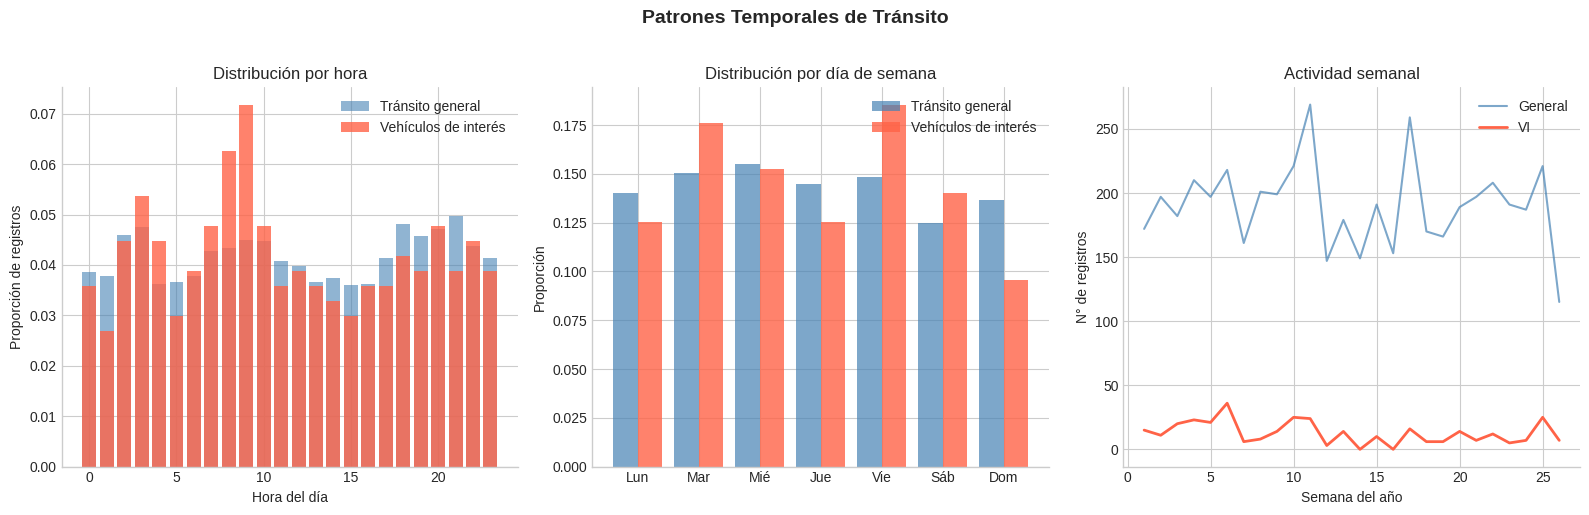

Figura guardada en ../figures/eda_temporal.png


In [104]:

# Instalación de dependencias necesarias
!pip install pandas numpy matplotlib seaborn scikit-learn networkx folium -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import networkx as nx
import os
from datetime import datetime, timedelta
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

# Configuración visual
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
sns.set_palette('husl')

# ============================================================
# CREACION DE VARIABLES DE TIEMPO
# ============================================================

df['timestamp'] = pd.to_datetime(df['timestamp'])

df['hora']     = df['timestamp'].dt.hour
df['dia_sem']  = df['timestamp'].dt.dayofweek
df['semana']   = df['timestamp'].dt.isocalendar().week.astype(int)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('Patrones Temporales de Tránsito', fontsize=14, fontweight='bold', y=1.02)

# Distribución por hora del día
hora_vi  = df[df['es_vi'] == 1]['hora'].value_counts().sort_index()
hora_all = df[df['es_vi'] == 0]['hora'].value_counts().sort_index()

axes[0].bar(hora_all.index, hora_all.values / hora_all.values.sum(),
            alpha=0.6, label='Tránsito general', color='steelblue')
axes[0].bar(hora_vi.index, hora_vi.values / hora_vi.values.sum(),
            alpha=0.8, label='Vehículos de interés', color='tomato')
axes[0].set_xlabel('Hora del día')
axes[0].set_ylabel('Proporción de registros')
axes[0].set_title('Distribución por hora')
axes[0].legend()

# Distribución por día de la semana
dias = ['Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb', 'Dom']
dsem_vi  = df[df['es_vi'] == 1]['dia_sem'].value_counts().sort_index()
dsem_all = df[df['es_vi'] == 0]['dia_sem'].value_counts().sort_index()

x = np.arange(7)
axes[1].bar(x - 0.2, dsem_all.reindex(range(7), fill_value=0).values / dsem_all.sum(),
            width=0.4, alpha=0.7, label='Tránsito general', color='steelblue')
axes[1].bar(x + 0.2, dsem_vi.reindex(range(7), fill_value=0).values / dsem_vi.sum(),
            width=0.4, alpha=0.8, label='Vehículos de interés', color='tomato')
axes[1].set_xticks(x)
axes[1].set_xticklabels(dias)
axes[1].set_ylabel('Proporción')
axes[1].set_title('Distribución por día de semana')
axes[1].legend()

# Actividad semanal a lo largo del tiempo
semanal = df.groupby(['semana', 'es_vi']).size().unstack(fill_value=0)
if 1 in semanal.columns:
    axes[2].plot(semanal.index, semanal[0], label='General', color='steelblue', alpha=0.7)
    axes[2].plot(semanal.index, semanal[1], label='VI', color='tomato', linewidth=2)
axes[2].set_xlabel('Semana del año')
axes[2].set_ylabel('N° de registros')
axes[2].set_title('Actividad semanal')
axes[2].legend()

plt.tight_layout()
os.makedirs('../figures', exist_ok=True)
plt.savefig('../figures/eda_temporal.png', dpi=150, bbox_inches='tight')
plt.show()
print('Figura guardada en ../figures/eda_temporal.png')

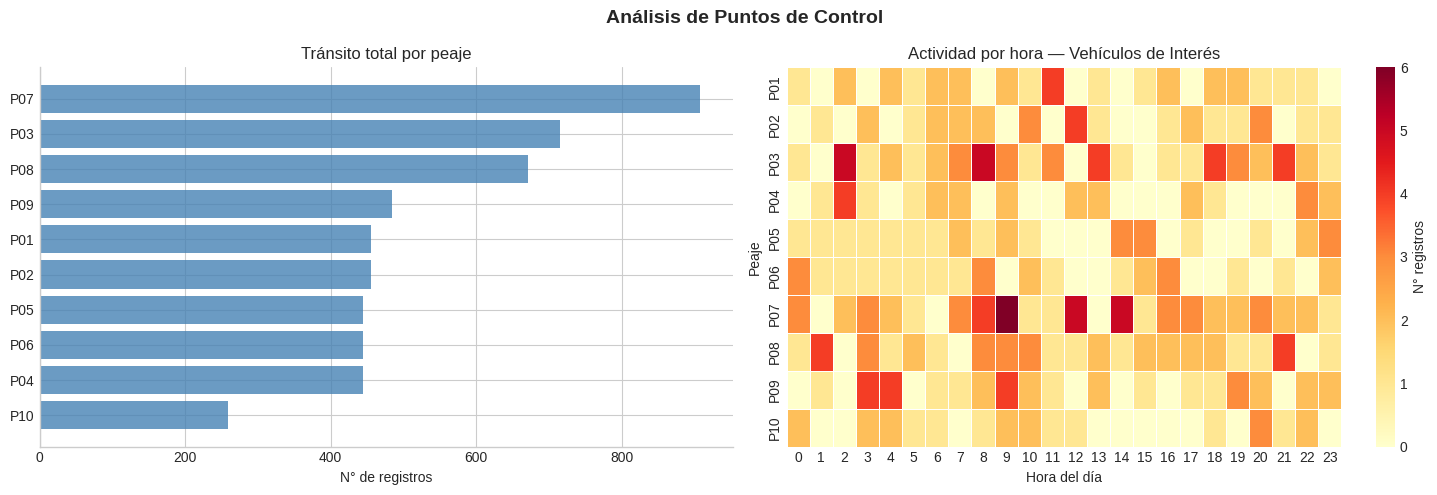

In [105]:
# ============================================================
# Análisis de uso de peajes
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Análisis de Puntos de Control', fontsize=14, fontweight='bold')

# Frecuencia de uso por peaje
uso_peaje = df.groupby('peaje_id').size().sort_values(ascending=True)
axes[0].barh(uso_peaje.index, uso_peaje.values, color='steelblue', alpha=0.8)
axes[0].set_xlabel('N° de registros')
axes[0].set_title('Tránsito total por peaje')

# Heatmap: hora del día vs peaje (solo VI)
pivot_vi = df[df['es_vi'] == 1].groupby(['peaje_id', 'hora']).size().unstack(fill_value=0)
sns.heatmap(pivot_vi, ax=axes[1], cmap='YlOrRd', linewidths=0.5,
            cbar_kws={'label': 'N° registros'}, annot=False)
axes[1].set_title('Actividad por hora — Vehículos de Interés')
axes[1].set_xlabel('Hora del día')
axes[1].set_ylabel('Peaje')

plt.tight_layout()
plt.savefig('../figures/eda_peajes.png', dpi=150, bbox_inches='tight')
plt.show()

In [106]:
# ============================================================
# VARIABLES vehiculares individuales
# ============================================================

# DEFINICION DE VARIABLES:
PEAJES = {
    'P01': {'nombre': 'Peaje Norte-Entrada',   'lat': -14.05, 'lon': -75.73, 'ruta': 'R1'},
    'P02': {'nombre': 'Peaje Norte-Central',   'lat': -14.32, 'lon': -75.65, 'ruta': 'R1'},
    'P03': {'nombre': 'Peaje Norte-Salida',    'lat': -14.58, 'lon': -75.48, 'ruta': 'R1'},
    'P04': {'nombre': 'Peaje Sur-Entrada',     'lat': -15.12, 'lon': -75.20, 'ruta': 'R2'},
    'P05': {'nombre': 'Peaje Sur-Central',     'lat': -15.38, 'lon': -74.95, 'ruta': 'R2'},
    'P06': {'nombre': 'Peaje Sur-Salida',      'lat': -15.65, 'lon': -74.72, 'ruta': 'R2'},
    'P07': {'nombre': 'Peaje Cruce-Norte',     'lat': -14.85, 'lon': -75.10, 'ruta': 'R3'},
    'P08': {'nombre': 'Peaje Cruce-Sur',       'lat': -15.02, 'lon': -74.88, 'ruta': 'R3'},
    'P09': {'nombre': 'Peaje Ramal-A',         'lat': -14.50, 'lon': -74.60, 'ruta': 'R4'},
    'P10': {'nombre': 'Peaje Ramal-B',         'lat': -14.78, 'lon': -74.45, 'ruta': 'R4'},
}

# Rutas definidas como secuencias de peajes
RUTAS = {
    'ruta_norte':    ['P01', 'P02', 'P03', 'P07'],
    'ruta_sur':      ['P04', 'P05', 'P06', 'P08'],
    'ruta_cruce':    ['P07', 'P08'],
    'ruta_ramal':    ['P03', 'P09', 'P10'],
    'ruta_completa': ['P01', 'P02', 'P03', 'P07', 'P08', 'P05', 'P06'],
    'ruta_corta':    ['P04', 'P07', 'P09'],
}


feats_vehiculares = df.groupby('placa').agg(
    total_registros     = ('timestamp', 'count'),
    peajes_distintos    = ('peaje_id', 'nunique'),
    dias_activo         = ('timestamp', lambda x: (x.max() - x.min()).days + 1),
    primer_registro     = ('timestamp', 'min'),
    ultimo_registro     = ('timestamp', 'max'),
).reset_index()

# Frecuencia de actividad
feats_vehiculares['registros_por_dia'] = (
    feats_vehiculares['total_registros'] / feats_vehiculares['dias_activo'].clip(lower=1)
).round(3)

# Cobertura de red (qué proporción de peajes visita)
feats_vehiculares['cobertura_red'] = (
    feats_vehiculares['peajes_distintos'] / len(PEAJES)
).round(3)

# Patrones temporales
hora_stats = df.groupby('placa')['hora'].agg(['mean', 'std']).rename(
    columns={'mean': 'hora_media', 'std': 'hora_std'}
).fillna(0)

prop_noche = df.copy()
prop_noche['es_nocturno'] = prop_noche['hora'].apply(lambda h: 1 if (h >= 22 or h <= 5) else 0)
prop_noche = prop_noche.groupby('placa')['es_nocturno'].mean().rename('prop_viajes_nocturnos')

prop_finde = df.copy()
prop_finde['es_finde'] = (prop_finde['dia_sem'] >= 5).astype(int)
prop_finde = prop_finde.groupby('placa')['es_finde'].mean().rename('prop_viajes_finde')

feats_vehiculares = feats_vehiculares.merge(hora_stats, on='placa', how='left')
feats_vehiculares = feats_vehiculares.merge(prop_noche, on='placa', how='left')
feats_vehiculares = feats_vehiculares.merge(prop_finde, on='placa', how='left')

# Peaje favorito (el más visitado)
peaje_fav = df.groupby('placa')['peaje_id'].agg(lambda x: x.value_counts().index[0]).rename('peaje_favorito')
feats_vehiculares = feats_vehiculares.merge(peaje_fav, on='placa', how='left')

print(f'Features vehiculares: {feats_vehiculares.shape[1] - 1} variables para {feats_vehiculares.shape[0]} vehículos')
feats_vehiculares.head()

Features vehiculares: 12 variables para 200 vehículos


,placa,total_registros,peajes_distintos,dias_activo,primer_registro,ultimo_registro,registros_por_dia,cobertura_red,hora_media,hora_std,prop_viajes_nocturnos,prop_viajes_finde,peaje_favorito
0,AAV-420,37,10,130,2024-01-31 00:28:46,2024-06-08 12:57:06,0.285,1.0,11.081081,9.187487,0.540541,0.216216,P08
1,ACE-204,27,10,144,2024-02-03 09:57:16,2024-06-26 00:49:00,0.188,1.0,11.259259,6.688639,0.259259,0.555556,P08
2,AEZ-995,24,10,124,2024-01-28 22:36:05,2024-05-31 01:29:56,0.194,1.0,12.375000,9.239859,0.583333,0.500000,P07
3,AHK-121,9,8,91,2024-03-06 11:00:35,2024-06-04 15:47:21,0.099,0.8,14.000000,2.179449,0.000000,0.444444,P08
4,ALU-692,30,10,103,2024-03-04 03:55:58,2024-06-14 13:34:28,0.291,1.0,6.300000,3.583006,0.466667,0.233333,P07


In [ ]:
# ============================================================
# VARIABLES de co-ocurrencia con Vehículos de Interés
# ============================================================
#
# Una "co-ocurrencia" se define como: dos vehículos pasan por
# el MISMO peaje dentro de una ventana de WINDOW_ACOMPAÑAMIENTO
# minutos. Esta es la señal principal de acompañamiento.
# ============================================================


WINDOW_ACOMPAÑAMIENTO = 30 #INTERVALO DE 30 MINUTOS
WINDOW_SEG = WINDOW_ACOMPAÑAMIENTO * 60  # convertir a segundos

print('='*55)
print('CARGANDO LA VERDAD DE LOS DATOS')
print('='*55)

# Cargar el mapeo de ground truth
tipo_map_df = pd.read_csv(BASE_PATH + 'tipo_vehiculo_map.csv')

# Registros por tipo de vehículo
tipo_map = {}

# Hacer merge con el dataframe principal
df = df.merge(tipo_map_df, on='placa', how='left')

# Crear variable objetivo correcta
df['es_liebre'] = df['tipo_vehiculo'].isin(['Liebre Real', 'Liebre Ocasional']).astype(int)

# Resumen por tipo de vehículo
resumen = df.groupby('tipo_vehiculo').agg(
    vehiculos=('placa', 'nunique'),
    registros=('placa', 'count')
).assign(registros_por_vehiculo=lambda x: (x['registros'] / x['vehiculos']).round(1))

print(resumen.to_string())
print()
print(f'NOTA: El modelo solo verá la columna es_vi (0/1).')
print(f'La columna tipo_vehiculo es ground truth para evaluación interna.')

# Los VI son los objetivos conocidos
registros_vi = df[df['es_vi'] == 1][['placa', 'timestamp', 'peaje_id']].copy()
registros_vi.columns = ['placa_vi', 'timestamp_vi', 'peaje_id']

# Los candidatos son todos los NO-VI (aquí están las liebres ocultas)
registros_candidatos = df[df['es_vi'] == 0][['placa', 'timestamp', 'peaje_id']].copy()

# Cross-join por peaje
merged = registros_candidatos.merge(registros_vi, on='peaje_id', how='inner')

merged['delta_segundos'] = abs(
    (merged['timestamp'] - merged['timestamp_vi']).dt.total_seconds()
)
coocurrencias = merged[merged['delta_segundos'] <= WINDOW_SEG].copy()

# Agregar por placa candidata
feats_cooc = coocurrencias.groupby('placa').agg(
    n_coocurrencias_total   = ('placa_vi', 'count'),
    n_vi_distintos          = ('placa_vi', 'nunique'),
    n_peajes_con_cooc       = ('peaje_id', 'nunique'),
    delta_medio_segundos    = ('delta_segundos', 'mean'),
    delta_min_segundos      = ('delta_segundos', 'min'),
).reset_index()

# ).reset_index().rename(columns={'placa': 'placa'})

feats_cooc['delta_medio_minutos'] = (feats_cooc['delta_medio_segundos'] / 60).round(2)
feats_cooc['delta_min_minutos']   = (feats_cooc['delta_min_segundos'] / 60).round(2)

# Ratio de co-ocurrencia: co-ocurrencias / total registros del vehículo
feats_cooc = feats_cooc.merge(
    feats_vehiculares[['placa', 'total_registros']], on='placa', how='left'
)
feats_cooc['ratio_coocurrencia'] = (
    feats_cooc['n_coocurrencias_total'] / feats_cooc['total_registros']
).round(4)

print(f'Vehículos con al menos 1 co-ocurrencia con VI: {len(feats_cooc):,}')
print(f'Features de co-ocurrencia: {feats_cooc.shape[1] - 1} variables')

# Distribución por tipo
tipos_unicos = df[['placa', 'tipo_vehiculo']].drop_duplicates()
feats_cooc_tipo = feats_cooc.merge(tipos_unicos, on='placa', how='left')
print('\nResumen de co-ocurrencias por tipo de vehículo:')
feats_cooc_tipo.groupby('tipo_vehiculo')['n_coocurrencias_total'].describe().round(1)

In [108]:
# ============================================================
# VARIABLES de secuencia de rutas
# ============================================================

# Construir rutas observadas por vehículo (secuencia de peajes por viaje)
df_sorted = df.sort_values(['placa', 'timestamp']).copy()

# Identificar "viajes" (gap > 4 horas entre registros consecutivos del mismo vehículo)
GAP_VIAJE_HORAS = 4
df_sorted['prev_timestamp'] = df_sorted.groupby('placa')['timestamp'].shift(1)
df_sorted['gap_horas'] = (
    (df_sorted['timestamp'] - df_sorted['prev_timestamp']).dt.total_seconds() / 3600
).fillna(999)
df_sorted['viaje_id'] = (df_sorted['gap_horas'] > GAP_VIAJE_HORAS).astype(int)
df_sorted['viaje_id'] = df_sorted.groupby('placa')['viaje_id'].cumsum()

# Por viaje: distancia recorrida (número de peajes) y duración
viajes = df_sorted.groupby(['placa', 'viaje_id']).agg(
    n_peajes_viaje  = ('peaje_id', 'count'),
    duracion_mins   = ('timestamp', lambda x: (x.max() - x.min()).total_seconds() / 60),
    ruta_str        = ('peaje_id', lambda x: '-'.join(x.values)),
).reset_index()

# Agregar por vehículo
feats_secuencia = viajes.groupby('placa').agg(
    n_viajes                = ('viaje_id', 'count'),
    media_peajes_por_viaje  = ('n_peajes_viaje', 'mean'),
    std_peajes_por_viaje    = ('n_peajes_viaje', 'std'),
    media_duracion_mins     = ('duracion_mins', 'mean'),
    n_rutas_distintas       = ('ruta_str', 'nunique'),
).reset_index().fillna(0)

# Concentración de rutas: si repite siempre la misma ruta = alta concentración
ruta_concentracion = viajes.groupby('placa').apply(
    lambda x: x['ruta_str'].value_counts().iloc[0] / len(x) if len(x) > 0 else 0
).rename('concentracion_ruta_principal').reset_index()
ruta_concentracion.columns = ['placa', 'concentracion_ruta_principal']

feats_secuencia = feats_secuencia.merge(ruta_concentracion, on='placa', how='left')

print(f'Features de secuencia: {feats_secuencia.shape[1] - 1} variables')
feats_secuencia.head()

Features de secuencia: 6 variables


,placa,n_viajes,media_peajes_por_viaje,std_peajes_por_viaje,media_duracion_mins,n_rutas_distintas,concentracion_ruta_principal
0,AAV-420,9,4.111111,2.260777,149.000000,4,0.333333
1,ACE-204,7,3.857143,1.573592,144.857143,5,0.285714
2,AEZ-995,5,4.800000,2.049390,184.400000,4,0.400000
3,AHK-121,3,3.000000,1.000000,90.333333,3,0.333333
4,ALU-692,7,4.285714,1.976047,157.857143,6,0.285714


In [110]:
# ============================================================
# consolidacion de varibles para embeddings
# ============================================================

# Unir todas las familias de features
feature_matrix = feats_vehiculares[[
    'placa', 'total_registros', 'peajes_distintos', 'dias_activo',
    'registros_por_dia', 'cobertura_red', 'hora_media', 'hora_std',
    'prop_viajes_nocturnos', 'prop_viajes_finde'
]].merge(feats_cooc[[
    'placa', 'n_coocurrencias_total', 'n_vi_distintos',
    'n_peajes_con_cooc', 'delta_medio_minutos', 'ratio_coocurrencia'
]], on='placa', how='left'
).merge(feats_secuencia[[
    'placa', 'n_viajes', 'media_peajes_por_viaje', 'std_peajes_por_viaje',
    'media_duracion_mins', 'n_rutas_distintas', 'concentracion_ruta_principal'
]], on='placa', how='left')

# Rellenar NaN en features de co-ocurrencia (vehículos sin ninguna co-ocurrencia)
cols_cooc = ['n_coocurrencias_total', 'n_vi_distintos', 'n_peajes_con_cooc',
             'delta_medio_minutos', 'ratio_coocurrencia']
feature_matrix[cols_cooc] = feature_matrix[cols_cooc].fillna(0)

# Agregar variable objetivo y tipo para evaluación
etiquetas = df[['placa', 'es_vi', 'tipo_vehiculo']].drop_duplicates()
feature_matrix = feature_matrix.merge(etiquetas, on='placa', how='left')

# ✅ Crear es_liebre directamente en feature_matrix
feature_matrix['es_liebre'] = feature_matrix['tipo_vehiculo'].isin(['Liebre Real', 'Liebre Ocasional']).astype(int)

print(f'Feature matrix final:')
print(f'  Forma:        {feature_matrix.shape}')
print(f'  Variables:    {feature_matrix.shape[1] - 4}  (sin placa, es_vi, es_liebre, tipo_vehiculo)')
print(f'  Vehículos:    {len(feature_matrix)}')
print()
print(f'DISTRIBUCIÓN DE CLASES:')
print(f'  VI (es_vi=1):          {feature_matrix["es_vi"].sum()}')
print(f'  Liebres (es_liebre=1): {feature_matrix["es_liebre"].sum()}')
print(f'  Normales:              {((feature_matrix["es_vi"]==0) & (feature_matrix["es_liebre"]==0)).sum()}')
print()
print('Columnas con valores nulos:')
nulls = feature_matrix.isnull().sum()
print(nulls[nulls > 0] if nulls.any() else '  Ninguna ✅')
print(nulls[nulls > 0] if nulls.any() else '  Ninguna ✅')

Feature matrix final:
  Forma:        (200, 24)
  Variables:    20  (sin placa, es_vi, es_liebre, tipo_vehiculo)
  Vehículos:    200

DISTRIBUCIÓN DE CLASES:
  VI (es_vi=1):          15
  Liebres (es_liebre=1): 45
  Normales:              140

Columnas con valores nulos:
  Ninguna ✅
  Ninguna ✅


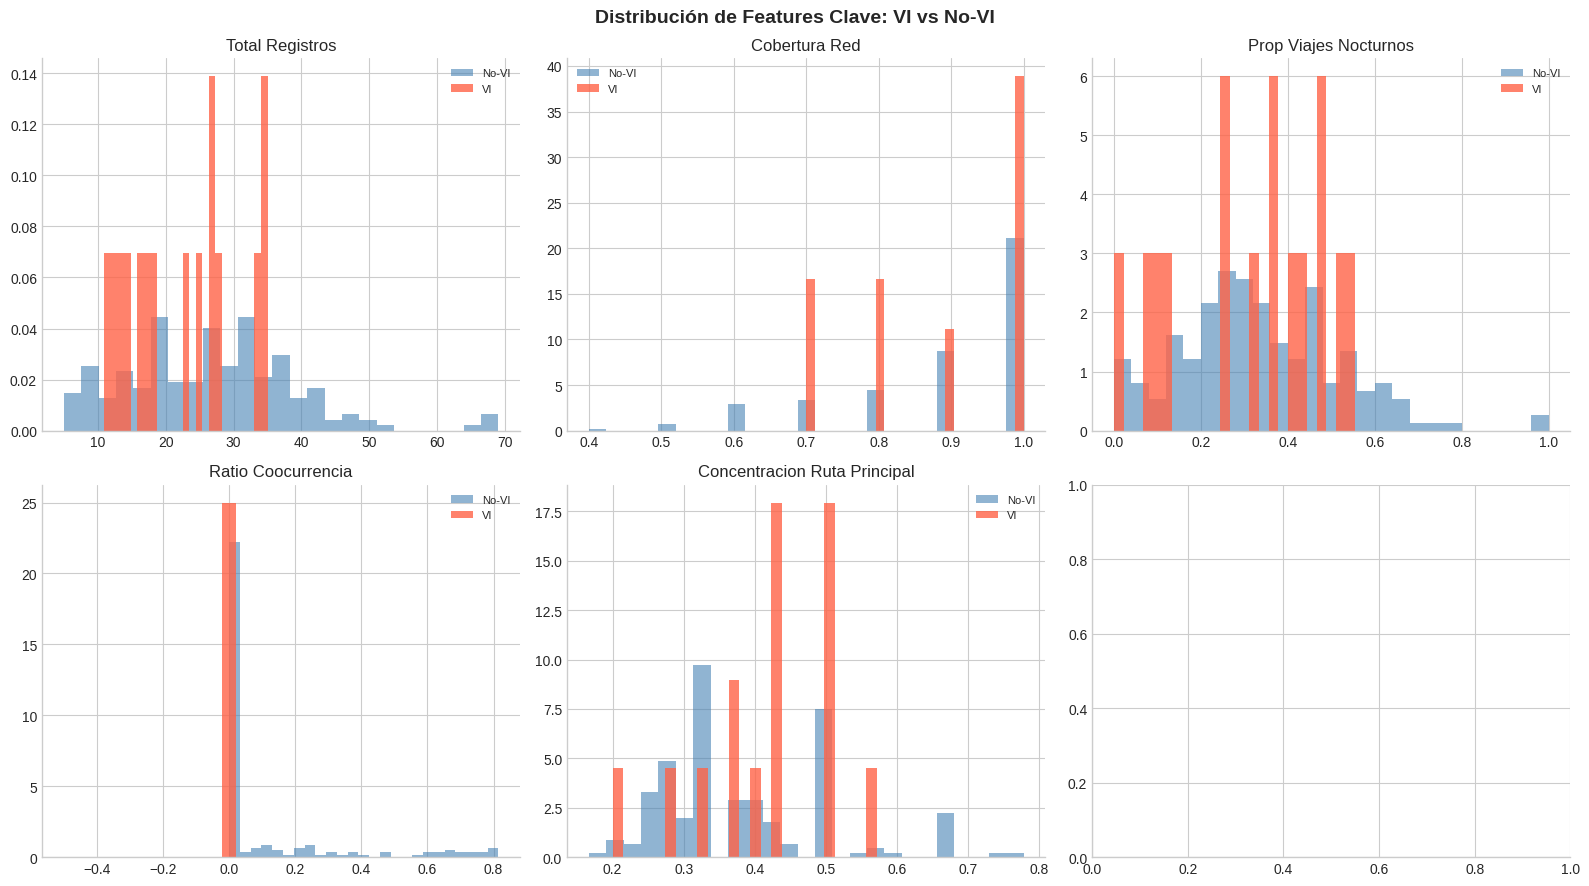

In [111]:
# ============================================================
# Análisis de features: distribución VI vs No-VI
# ============================================================

features_numericas = [
    'total_registros', 'cobertura_red', 'prop_viajes_nocturnos',
     'ratio_coocurrencia', 'concentracion_ruta_principal'
]

fig, axes = plt.subplots(2, 3, figsize=(16, 9))
fig.suptitle('Distribución de Features Clave: VI vs No-VI', fontsize=14, fontweight='bold')
axes = axes.flatten()

for i, feat in enumerate(features_numericas):
    vi_vals   = feature_matrix[feature_matrix['es_vi'] == 1][feat].dropna()
    novi_vals = feature_matrix[feature_matrix['es_vi'] == 0][feat].dropna()

    axes[i].hist(novi_vals, bins=25, alpha=0.6, color='steelblue', label='No-VI', density=True)
    axes[i].hist(vi_vals, bins=25, alpha=0.8, color='tomato', label='VI', density=True)
    axes[i].set_title(feat.replace('_', ' ').title())
    axes[i].legend(fontsize=8)

plt.tight_layout()
plt.savefig('../figures/features_distribucion.png', dpi=150, bbox_inches='tight')
plt.show()

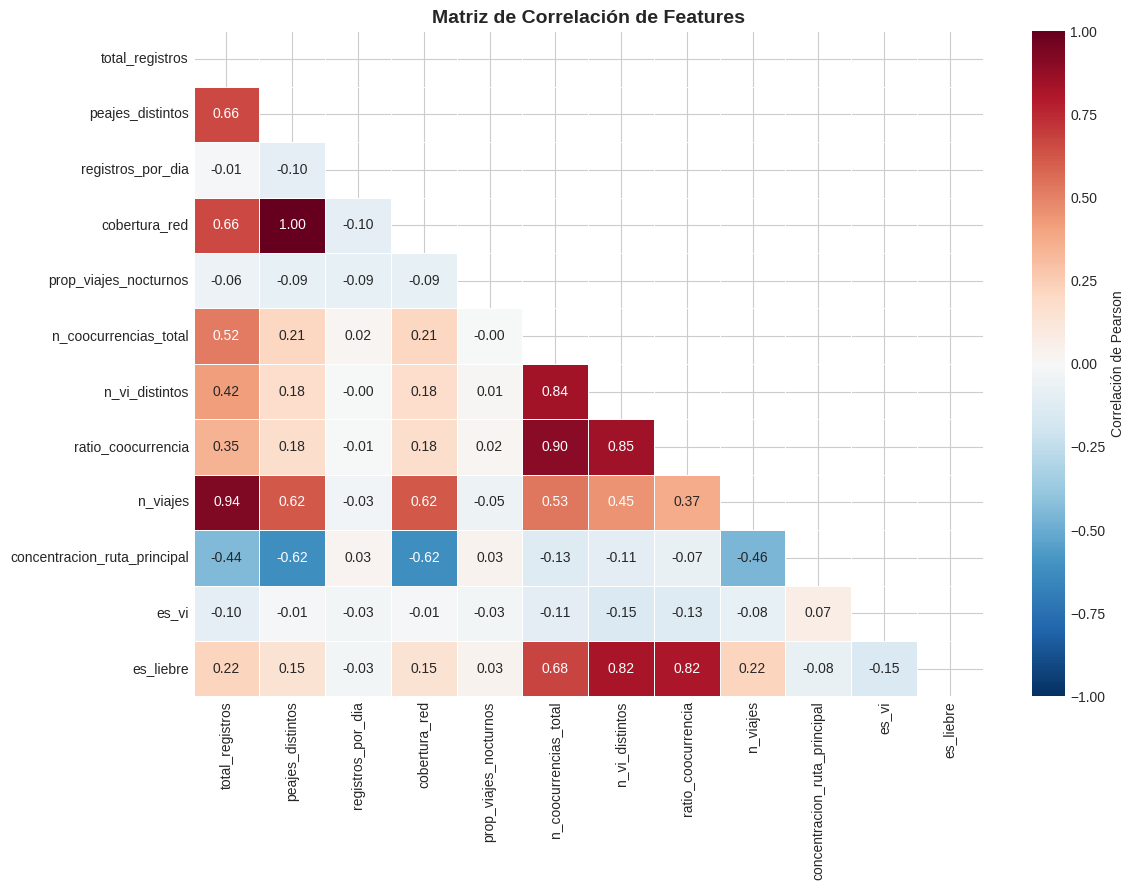

Correlación con variable objetivo (es_liebre):
n_vi_distintos                  0.825
ratio_coocurrencia              0.820
n_coocurrencias_total           0.679
n_viajes                        0.224
total_registros                 0.221
es_vi                          -0.153
peajes_distintos                0.148
cobertura_red                   0.148
concentracion_ruta_principal   -0.077
prop_viajes_nocturnos           0.032
registros_por_dia              -0.030

Para referencia - Correlación con es_vi (NO es objetivo):
es_liebre                      -0.153
n_vi_distintos                 -0.152
ratio_coocurrencia             -0.133
n_coocurrencias_total          -0.108
total_registros                -0.096
n_viajes                       -0.084
concentracion_ruta_principal    0.071
prop_viajes_nocturnos          -0.025
registros_por_dia              -0.025
cobertura_red                  -0.013
peajes_distintos               -0.013


In [114]:
# ============================================================
# Correlación entre features
# ============================================================

feat_cols = [
    'total_registros', 'peajes_distintos', 'registros_por_dia', 'cobertura_red',
    'prop_viajes_nocturnos', 'n_coocurrencias_total', 'n_vi_distintos',
    'ratio_coocurrencia', 'n_viajes', 'concentracion_ruta_principal',
    'es_vi', 'es_liebre'  # ✅ Agregar es_liebre
]

corr_matrix = feature_matrix[feat_cols].corr()

fig, ax = plt.subplots(figsize=(12, 9))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, ax=ax, cmap='RdBu_r', center=0,
            annot=True, fmt='.2f', linewidths=0.5, vmin=-1, vmax=1,
            cbar_kws={'label': 'Correlación de Pearson'})
ax.set_title('Matriz de Correlación de Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../figures/correlacion_features.png', dpi=150, bbox_inches='tight')
plt.show()

# ✅ CAMBIO: Analizar correlación con es_liebre (variable objetivo real)
print('='*60)
print('Correlación con variable objetivo (es_liebre):')
print('='*60)
corr_con_liebre = corr_matrix['es_liebre'].drop('es_liebre').sort_values(key=abs, ascending=False)
print(corr_con_liebre.round(3).to_string())

print('\n' + '='*60)
print('Para referencia - Correlación con es_vi (NO es objetivo):')
print('='*60)
corr_con_vi = corr_matrix['es_vi'].drop('es_vi').sort_values(key=abs, ascending=False)
print(corr_con_vi.round(3).to_string())


In [120]:
# ============================================================
# Guardar feature matrix
# ============================================================

# Feature matrix completa (con todas las columnas)
feature_matrix.to_csv(BASE_PATH + 'feature_matrix_etapa1.csv', index=False)

# Solo features numéricas para el modelo (sin tipo_vehiculo )
X = feature_matrix.drop(columns=['placa', 'es_liebre', 'tipo_vehiculo', 'primer_registro',
                                   'ultimo_registro'], errors='ignore')
y = feature_matrix['es_liebre']

X.to_csv(BASE_PATH + 'X_etapa1.csv', index=False)
y.to_csv(BASE_PATH + 'y_etapa1.csv', index=False)


# Obtener las placas para cada categoría desde tipo_map_df
placas_vi = tipo_map_df[tipo_map_df['tipo_vehiculo'] == 'VI (Interés)']['placa'].tolist()
placas_liebres_r = tipo_map_df[tipo_map_df['tipo_vehiculo'] == 'Liebre Real']['placa'].tolist()
placas_liebres_o = tipo_map_df[tipo_map_df['tipo_vehiculo'] == 'Liebre Ocasional']['placa'].tolist()
placas_normales = tipo_map_df[tipo_map_df['tipo_vehiculo'] == 'Normal']['placa'].tolist()


# Diccionario de ground truth para evaluación en etapas siguientes
ground_truth = {
    'VI':            set(placas_vi),
    'Liebres_reales':     set(placas_liebres_r),
    'Liebres_ocasionales': set(placas_liebres_o),
    'Normales':       set(placas_normales),
}
import json
with open(BASE_PATH + 'ground_truth.json', 'w') as f:
    json.dump({k: list(v) for k, v in ground_truth.items()}, f, indent=2)

print('Artefactos guardados:')
print('  ../data/registros_peaje_sintetico.csv  — Dataset crudo')
print('  ../results/feature_matrix_etapa1.csv  — Feature matrix completa')
print('  ../results/X_etapa1.csv               — Features para modelo')
print('  ../results/y_etapa1.csv               — Variable objetivo')
print('  ../results/ground_truth.json          — Ground truth para evaluación')

Artefactos guardados:
  ../data/registros_peaje_sintetico.csv  — Dataset crudo
  ../results/feature_matrix_etapa1.csv  — Feature matrix completa
  ../results/X_etapa1.csv               — Features para modelo
  ../results/y_etapa1.csv               — Variable objetivo
  ../results/ground_truth.json          — Ground truth para evaluación


### 5.3.2 Codificación de Variables Categóricas

In [116]:
# =====================================================
# CODIFICACIÓN DE VARIABLES CATEGÓRICAS - todas las variales son numericas
# =====================================================

print("=" * 60)
print("CODIFICACIÓN DE VARIABLES CATEGÓRICAS")
print("=" * 60)

# Identificar variables categóricas
#categorical_cols = df_clean.select_dtypes(include=['object', 'category']).columns.tolist()
#print(f"\nVariables categóricas encontradas: {categorical_cols}")

# Opción 1: Label Encoding (para variables ordinales o target)
# le = LabelEncoder()
# df_clean['columna_encoded'] = le.fit_transform(df_clean['columna'])

# Opción 2: One-Hot Encoding (para variables nominales)
# df_clean = pd.get_dummies(df_clean, columns=categorical_cols, drop_first=True)

# Opción 3: Target Encoding
# from sklearn.preprocessing import TargetEncoder
# encoder = TargetEncoder()
# df_clean[categorical_cols] = encoder.fit_transform(df_clean[categorical_cols], df_clean[TARGET_COLUMN])

# =====================================================
# COMPLETE AQUÍ: Aplique su estrategia de codificación
# =====================================================



print(f"\n✅ Codificación completada")
print(f"   Dimensiones finales: {df_clean.shape}")

CODIFICACIÓN DE VARIABLES CATEGÓRICAS

✅ Codificación completada
   Dimensiones finales: (5284, 4)


### 5.4 Escalado/Normalización de Features

In [ ]:
# =====================================================
# ESCALADO DE FEATURES
# =====================================================

# COMPLETE: Especifique el nombre de su variable objetivo
TARGET_COLUMN = 'es_liebre'  # Cambie 'target' por el nombre de su variable objetivo

print("=" * 60)
print("ESCALADO DE FEATURES")
print("=" * 60)

# Separar features y target
X = df_clean.drop(columns=[TARGET_COLUMN])
y = df_clean[TARGET_COLUMN]

print(f"\nDimensiones de X: {X.shape}")
print(f"Dimensiones de y: {y.shape}")

# Opción 1: StandardScaler (media=0, std=1) - Recomendado para redes neuronales
scaler = StandardScaler()

# Opción 2: MinMaxScaler (rango [0,1])
# scaler = MinMaxScaler()

# Opción 3: RobustScaler (robusto a outliers)
# from sklearn.preprocessing import RobustScaler
# scaler = RobustScaler()

# Aplicar escalado
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

print(f"\n✅ Escalado completado usando {type(scaler).__name__}")
print(f"   Media de features: {X_scaled.mean().mean():.6f}")
print(f"   Std de features: {X_scaled.std().mean():.6f}")

### 5.5 División de Datos (Train/Validation/Test)

In [ ]:
# =====================================================
# DIVISIÓN DE DATOS
# =====================================================

print("=" * 60)
print("DIVISIÓN DE DATOS")
print("=" * 60)

# División en train (70%), validation (15%), test (15%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_scaled, y, test_size=0.15, random_state=RANDOM_SEED, stratify=y if y.dtype == 'object' or y.nunique() < 20 else None
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=RANDOM_SEED, stratify=y_temp if y_temp.dtype == 'object' or y_temp.nunique() < 20 else None  # 0.176 ≈ 15% del total
)

print(f"\n📊 División de datos:")
print(f"   Training set:   {X_train.shape[0]:,} muestras ({X_train.shape[0]/len(X_scaled)*100:.1f}%)")
print(f"   Validation set: {X_val.shape[0]:,} muestras ({X_val.shape[0]/len(X_scaled)*100:.1f}%)")
print(f"   Test set:       {X_test.shape[0]:,} muestras ({X_test.shape[0]/len(X_scaled)*100:.1f}%)")

# Verificar distribución de clases (para clasificación)
if y.dtype == 'object' or y.nunique() < 20:
    print(f"\n📊 Distribución de clases en cada conjunto:")
    print(f"   Train: {dict(y_train.value_counts(normalize=True).round(3))}")
    print(f"   Val:   {dict(y_val.value_counts(normalize=True).round(3))}")
    print(f"   Test:  {dict(y_test.value_counts(normalize=True).round(3))}")

### 5.6 Preparación de Datos para Deep Learning

In [ ]:
# =====================================================
# PREPARACIÓN PARA PYTORCH
# =====================================================

print("=" * 60)
print("PREPARACIÓN DE DATOS PARA PYTORCH")
print("=" * 60)

# Convertir a tensores de PyTorch
X_train_tensor = torch.FloatTensor(X_train.values)
X_val_tensor = torch.FloatTensor(X_val.values)
X_test_tensor = torch.FloatTensor(X_test.values)

# Para clasificación
if y.dtype == 'object' or y.nunique() < 20:
    # Codificar labels si es necesario
    if y_train.dtype == 'object':
        label_encoder = LabelEncoder()
        y_train_encoded = label_encoder.fit_transform(y_train)
        y_val_encoded = label_encoder.transform(y_val)
        y_test_encoded = label_encoder.transform(y_test)
    else:
        y_train_encoded = y_train.values
        y_val_encoded = y_val.values
        y_test_encoded = y_test.values

    y_train_tensor = torch.LongTensor(y_train_encoded)
    y_val_tensor = torch.LongTensor(y_val_encoded)
    y_test_tensor = torch.LongTensor(y_test_encoded)
else:
    # Para regresión
    y_train_tensor = torch.FloatTensor(y_train.values).unsqueeze(1)
    y_val_tensor = torch.FloatTensor(y_val.values).unsqueeze(1)
    y_test_tensor = torch.FloatTensor(y_test.values).unsqueeze(1)

# Crear DataLoaders
BATCH_SIZE = 32  # Ajuste según su dataset

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\n✅ DataLoaders creados")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Batches de entrenamiento: {len(train_loader)}")
print(f"   Batches de validación: {len(val_loader)}")
print(f"   Batches de test: {len(test_loader)}")

In [ ]:
# =====================================================
# PREPARACIÓN PARA TENSORFLOW/KERAS (ALTERNATIVA)
# =====================================================

print("=" * 60)
print("PREPARACIÓN DE DATOS PARA TENSORFLOW/KERAS")
print("=" * 60)

# Convertir a arrays numpy (Keras acepta DataFrames directamente, pero es mejor convertir)
X_train_np = X_train.values.astype('float32')
X_val_np = X_val.values.astype('float32')
X_test_np = X_test.values.astype('float32')

# Para clasificación: One-hot encoding del target
if y.dtype == 'object' or y.nunique() < 20:
    num_classes = y.nunique()
    y_train_np = keras.utils.to_categorical(y_train_encoded, num_classes)
    y_val_np = keras.utils.to_categorical(y_val_encoded, num_classes)
    y_test_np = keras.utils.to_categorical(y_test_encoded, num_classes)
else:
    y_train_np = y_train.values.astype('float32')
    y_val_np = y_val.values.astype('float32')
    y_test_np = y_test.values.astype('float32')

print(f"\n✅ Datos preparados para TensorFlow/Keras")
print(f"   Shape X_train: {X_train_np.shape}")
print(f"   Shape y_train: {y_train_np.shape}")

---
## 6. Diseño y Arquitectura del Modelo

### 6.1 Justificación de la Arquitectura

**Instrucciones:** Justifique la elección de su arquitectura de red neuronal:
- ¿Por qué eligió este tipo de arquitectura?
- ¿Qué alternativas consideró?
- ¿Cómo determinó el número de capas y neuronas?

---

*[Escriba su justificación aquí]*



---

### 6.2 Definición del Modelo

In [ ]:
# =====================================================
# DEFINICIÓN DEL MODELO CON PYTORCH
# =====================================================

class NeuralNetwork(nn.Module):
    """
    Red Neuronal para [Clasificación/Regresión]

    Arquitectura:
    - Capa de entrada: [n_features] neuronas
    - Capas ocultas: [Describir]
    - Capa de salida: [n_outputs] neuronas
    """

    def __init__(self, input_size, hidden_sizes, output_size, dropout_rate=0.3):
        super(NeuralNetwork, self).__init__()

        layers = []
        prev_size = input_size

        # Capas ocultas
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            prev_size = hidden_size

        # Capa de salida
        layers.append(nn.Linear(prev_size, output_size))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# =====================================================
# CONFIGURACIÓN DEL MODELO
# =====================================================

INPUT_SIZE = X_train.shape[1]
HIDDEN_SIZES = [128, 64, 32]  # Ajuste según su problema
OUTPUT_SIZE = y.nunique() if (y.dtype == 'object' or y.nunique() < 20) else 1
DROPOUT_RATE = 0.3

# Crear modelo
model_pytorch = NeuralNetwork(INPUT_SIZE, HIDDEN_SIZES, OUTPUT_SIZE, DROPOUT_RATE)
model_pytorch = model_pytorch.to(device)

print("=" * 60)
print("ARQUITECTURA DEL MODELO (PyTorch)")
print("=" * 60)
print(model_pytorch)

# Contar parámetros
total_params = sum(p.numel() for p in model_pytorch.parameters())
trainable_params = sum(p.numel() for p in model_pytorch.parameters() if p.requires_grad)
print(f"\n📊 Parámetros totales: {total_params:,}")
print(f"   Parámetros entrenables: {trainable_params:,}")

In [ ]:
# =====================================================
# DEFINICIÓN DEL MODELO CON KERAS (ALTERNATIVA)
# =====================================================

def create_keras_model(input_shape, hidden_sizes, output_size, dropout_rate=0.3, task='classification'):
    """
    Crea un modelo de red neuronal con Keras.

    Args:
        input_shape: Dimensión de entrada
        hidden_sizes: Lista con el número de neuronas por capa oculta
        output_size: Número de neuronas de salida
        dropout_rate: Tasa de dropout
        task: 'classification' o 'regression'
    """
    model = keras.Sequential()

    # Capa de entrada
    model.add(layers.Input(shape=(input_shape,)))

    # Capas ocultas
    for hidden_size in hidden_sizes:
        model.add(layers.Dense(hidden_size))
        model.add(layers.BatchNormalization())
        model.add(layers.Activation('relu'))
        model.add(layers.Dropout(dropout_rate))

    # Capa de salida
    if task == 'classification':
        if output_size == 2:
            model.add(layers.Dense(1, activation='sigmoid'))
        else:
            model.add(layers.Dense(output_size, activation='softmax'))
    else:
        model.add(layers.Dense(1, activation='linear'))

    return model

# Crear modelo Keras
TASK = 'classification'  # Cambie a 'regression' si es necesario

model_keras = create_keras_model(
    input_shape=INPUT_SIZE,
    hidden_sizes=HIDDEN_SIZES,
    output_size=OUTPUT_SIZE,
    dropout_rate=DROPOUT_RATE,
    task=TASK
)

print("=" * 60)
print("ARQUITECTURA DEL MODELO (Keras)")
print("=" * 60)
model_keras.summary()

### 6.3 Diagrama de la Arquitectura

**Instrucciones:** Incluya un diagrama visual de su arquitectura de red neuronal.

---

*[Inserte diagrama o descripción visual de la arquitectura]*

```
Input Layer          Hidden Layer 1       Hidden Layer 2       Output Layer
[n features]   -->   [128 neurons]   -->  [64 neurons]    -->  [n classes]
                     + BatchNorm          + BatchNorm
                     + ReLU               + ReLU
                     + Dropout(0.3)       + Dropout(0.3)
```

---

---
## 7. Entrenamiento del Modelo

### 7.1 Configuración del Entrenamiento

In [ ]:
# =====================================================
# HIPERPARÁMETROS DE ENTRENAMIENTO
# =====================================================

print("=" * 60)
print("CONFIGURACIÓN DEL ENTRENAMIENTO")
print("=" * 60)

# Hiperparámetros
LEARNING_RATE = 0.001
EPOCHS = 100
BATCH_SIZE = 32
EARLY_STOPPING_PATIENCE = 10

print(f"\n📋 Hiperparámetros:")
print(f"   Learning Rate: {LEARNING_RATE}")
print(f"   Epochs: {EPOCHS}")
print(f"   Batch Size: {BATCH_SIZE}")
print(f"   Early Stopping Patience: {EARLY_STOPPING_PATIENCE}")

In [ ]:
# =====================================================
# CONFIGURACIÓN DE LOSS Y OPTIMIZADOR (PyTorch)
# =====================================================

# Seleccionar función de pérdida según el tipo de problema
if y.dtype == 'object' or y.nunique() < 20:
    # Clasificación
    criterion = nn.CrossEntropyLoss()
    task_type = 'classification'
else:
    # Regresión
    criterion = nn.MSELoss()
    task_type = 'regression'

# Optimizador
optimizer = optim.Adam(model_pytorch.parameters(), lr=LEARNING_RATE)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True
)

print(f"\n📋 Configuración:")
print(f"   Tipo de problema: {task_type}")
print(f"   Función de pérdida: {criterion}")
print(f"   Optimizador: Adam")
print(f"   Scheduler: ReduceLROnPlateau")

### 7.2 Entrenamiento del Modelo (PyTorch)

In [ ]:
# =====================================================
# FUNCIONES DE ENTRENAMIENTO Y EVALUACIÓN
# =====================================================

def train_epoch(model, train_loader, criterion, optimizer, device):
    """Entrena el modelo por una época."""
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if task_type == 'classification':
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    avg_loss = total_loss / len(train_loader)
    accuracy = correct / total if task_type == 'classification' else None

    return avg_loss, accuracy

def evaluate(model, val_loader, criterion, device):
    """Evalúa el modelo en el conjunto de validación."""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item()

            if task_type == 'classification':
                _, predicted = torch.max(outputs.data, 1)
                total += y_batch.size(0)
                correct += (predicted == y_batch).sum().item()

    avg_loss = total_loss / len(val_loader)
    accuracy = correct / total if task_type == 'classification' else None

    return avg_loss, accuracy

In [ ]:
# =====================================================
# ENTRENAMIENTO DEL MODELO (PyTorch)
# =====================================================

print("=" * 60)
print("ENTRENAMIENTO DEL MODELO")
print("=" * 60)

# Historial de entrenamiento
history = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': []
}

# Early stopping
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

print(f"\n🚀 Iniciando entrenamiento...\n")

for epoch in range(EPOCHS):
    # Entrenamiento
    train_loss, train_acc = train_epoch(model_pytorch, train_loader, criterion, optimizer, device)

    # Validación
    val_loss, val_acc = evaluate(model_pytorch, val_loader, criterion, device)

    # Guardar historial
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    if task_type == 'classification':
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

    # Scheduler step
    scheduler.step(val_loss)

    # Imprimir progreso cada 10 épocas
    if (epoch + 1) % 10 == 0 or epoch == 0:
        if task_type == 'classification':
            print(f"Época {epoch+1:3d}/{EPOCHS} | "
                  f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
                  f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
        else:
            print(f"Época {epoch+1:3d}/{EPOCHS} | "
                  f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = model_pytorch.state_dict().copy()
    else:
        patience_counter += 1
        if patience_counter >= EARLY_STOPPING_PATIENCE:
            print(f"\n⚠️ Early stopping en época {epoch+1}")
            break

# Cargar mejor modelo
if best_model_state is not None:
    model_pytorch.load_state_dict(best_model_state)
    print(f"\n✅ Mejor modelo cargado (Val Loss: {best_val_loss:.4f})")

print(f"\n🎉 Entrenamiento completado!")

### 7.3 Entrenamiento del Modelo (Keras - Alternativa)

In [ ]:
# =====================================================
# ENTRENAMIENTO DEL MODELO (KERAS)
# =====================================================

# Compilar modelo
if TASK == 'classification':
    if OUTPUT_SIZE == 2:
        model_keras.compile(
            optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
    else:
        model_keras.compile(
            optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
else:
    model_keras.compile(
        optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss='mse',
        metrics=['mae']
    )

# Callbacks
keras_callbacks = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=EARLY_STOPPING_PATIENCE,
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        verbose=1
    ),
    callbacks.ModelCheckpoint(
        'best_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=0
    )
]

# Entrenar
print("=" * 60)
print("ENTRENAMIENTO DEL MODELO (KERAS)")
print("=" * 60)

history_keras = model_keras.fit(
    X_train_np, y_train_np,
    validation_data=(X_val_np, y_val_np),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=keras_callbacks,
    verbose=1
)

print("\n🎉 Entrenamiento completado!")

### 7.4 Visualización del Entrenamiento

In [ ]:
# =====================================================
# VISUALIZACIÓN DEL PROCESO DE ENTRENAMIENTO
# =====================================================

print("=" * 60)
print("CURVAS DE APRENDIZAJE")
print("=" * 60)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de pérdida
axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2)
axes[0].plot(history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_title('Evolución de la Pérdida', fontsize=14)
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Gráfico de precisión (solo para clasificación)
if task_type == 'classification':
    axes[1].plot(history['train_acc'], label='Train Accuracy', linewidth=2)
    axes[1].plot(history['val_acc'], label='Validation Accuracy', linewidth=2)
    axes[1].set_title('Evolución de la Precisión', fontsize=14)
    axes[1].set_xlabel('Época')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
else:
    axes[1].text(0.5, 0.5, 'N/A para Regresión', ha='center', va='center', fontsize=14)
    axes[1].set_title('Precisión (No aplica)')

plt.tight_layout()
plt.show()

# Análisis del entrenamiento
print("\n📊 Análisis del Entrenamiento:")
print(f"   Épocas completadas: {len(history['train_loss'])}")
print(f"   Mejor val_loss: {min(history['val_loss']):.4f} (época {history['val_loss'].index(min(history['val_loss']))+1})")
if task_type == 'classification':
    print(f"   Mejor val_acc: {max(history['val_acc']):.4f} (época {history['val_acc'].index(max(history['val_acc']))+1})")

---
## 8. Evaluación y Métricas

### 8.1 Evaluación en el Conjunto de Test

In [ ]:
# =====================================================
# EVALUACIÓN EN EL CONJUNTO DE TEST
# =====================================================

print("=" * 60)
print("EVALUACIÓN EN CONJUNTO DE TEST")
print("=" * 60)

# Hacer predicciones
model_pytorch.eval()
with torch.no_grad():
    X_test_device = X_test_tensor.to(device)
    outputs = model_pytorch(X_test_device)

    if task_type == 'classification':
        _, y_pred = torch.max(outputs, 1)
        y_pred = y_pred.cpu().numpy()
        y_true = y_test_tensor.numpy()
        y_proba = torch.softmax(outputs, dim=1).cpu().numpy()
    else:
        y_pred = outputs.cpu().numpy().flatten()
        y_true = y_test_tensor.numpy().flatten()

print(f"\n✅ Predicciones realizadas: {len(y_pred)} muestras")

In [ ]:
# =====================================================
# MÉTRICAS DE CLASIFICACIÓN
# =====================================================

if task_type == 'classification':
    print("=" * 60)
    print("MÉTRICAS DE CLASIFICACIÓN")
    print("=" * 60)

    # Calcular métricas
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"\n📊 Métricas Principales:")
    print(f"   Accuracy:  {accuracy:.4f}")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall:    {recall:.4f}")
    print(f"   F1-Score:  {f1:.4f}")

    # Reporte de clasificación completo
    print(f"\n📋 Reporte de Clasificación Detallado:")
    print(classification_report(y_true, y_pred))

    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=range(OUTPUT_SIZE),
                yticklabels=range(OUTPUT_SIZE))
    plt.title('Matriz de Confusión', fontsize=14)
    plt.xlabel('Predicción')
    plt.ylabel('Valor Real')
    plt.tight_layout()
    plt.show()

In [ ]:
# =====================================================
# MÉTRICAS DE REGRESIÓN
# =====================================================

if task_type == 'regression':
    print("=" * 60)
    print("MÉTRICAS DE REGRESIÓN")
    print("=" * 60)

    # Calcular métricas
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n📊 Métricas de Regresión:")
    print(f"   MSE:  {mse:.4f}")
    print(f"   RMSE: {rmse:.4f}")
    print(f"   MAE:  {mae:.4f}")
    print(f"   R²:   {r2:.4f}")

    # Gráfico de predicciones vs valores reales
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Scatter plot
    axes[0].scatter(y_true, y_pred, alpha=0.5)
    axes[0].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    axes[0].set_xlabel('Valor Real')
    axes[0].set_ylabel('Predicción')
    axes[0].set_title('Predicciones vs Valores Reales')

    # Distribución de residuos
    residuos = y_true - y_pred
    axes[1].hist(residuos, bins=50, edgecolor='black')
    axes[1].axvline(x=0, color='r', linestyle='--')
    axes[1].set_xlabel('Residuo')
    axes[1].set_ylabel('Frecuencia')
    axes[1].set_title('Distribución de Residuos')

    plt.tight_layout()
    plt.show()

### 8.2 Comparación con Modelo Baseline

In [ ]:
# =====================================================
# COMPARACIÓN CON MODELO BASELINE
# =====================================================

print("=" * 60)
print("COMPARACIÓN CON MODELO BASELINE")
print("=" * 60)

if task_type == 'classification':
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.linear_model import LogisticRegression

    # Modelos baseline
    baselines = {
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=RANDOM_SEED),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED)
    }
else:
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.linear_model import LinearRegression

    baselines = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=RANDOM_SEED)
    }

# Entrenar y evaluar baselines
results = {'Modelo': [], 'Métrica': []}

for name, model in baselines.items():
    model.fit(X_train, y_train)
    y_pred_baseline = model.predict(X_test)

    if task_type == 'classification':
        metric = accuracy_score(y_test, y_pred_baseline)
        metric_name = 'Accuracy'
    else:
        metric = r2_score(y_test, y_pred_baseline)
        metric_name = 'R²'

    results['Modelo'].append(name)
    results['Métrica'].append(metric)

# Agregar modelo de Deep Learning
results['Modelo'].append('Deep Learning')
if task_type == 'classification':
    results['Métrica'].append(accuracy)
else:
    results['Métrica'].append(r2)

# Mostrar comparación
comparison_df = pd.DataFrame(results)
comparison_df = comparison_df.sort_values('Métrica', ascending=False)

print(f"\n📊 Comparación de Modelos ({metric_name}):")
display(comparison_df)

# Visualización
plt.figure(figsize=(10, 6))
colors = ['#2ecc71' if m == 'Deep Learning' else '#3498db' for m in comparison_df['Modelo']]
plt.barh(comparison_df['Modelo'], comparison_df['Métrica'], color=colors)
plt.xlabel(metric_name)
plt.title(f'Comparación de Modelos - {metric_name}')
plt.tight_layout()
plt.show()

### 8.3 Análisis de Resultados

**Instrucciones:** Analice los resultados obtenidos:

---

**Rendimiento del Modelo:**
*[Analice las métricas obtenidas]*

**Comparación con Baselines:**
*[Compare el rendimiento con los modelos baseline]*

**Fortalezas del Modelo:**
1. *[Completar]*
2. *[Completar]*

**Debilidades del Modelo:**
1. *[Completar]*
2. *[Completar]*

**Posibles Mejoras:**
1. *[Completar]*
2. *[Completar]*

---

---
## 9. Interpretación de Resultados

### 9.1 Importancia de Features (SHAP)

In [ ]:
# =====================================================
# INTERPRETABILIDAD CON SHAP (OPCIONAL)
# =====================================================

# Instalar SHAP si no está disponible
# !pip install shap

try:
    import shap

    print("=" * 60)
    print("ANÁLISIS DE IMPORTANCIA DE FEATURES (SHAP)")
    print("=" * 60)

    # Crear explainer
    # Usar una muestra del dataset para acelerar el cálculo
    sample_size = min(100, len(X_test))
    X_sample = X_test.iloc[:sample_size]

    # Para modelos de sklearn (baselines)
    explainer = shap.TreeExplainer(baselines['Random Forest'])
    shap_values = explainer.shap_values(X_sample)

    # Visualización
    plt.figure(figsize=(12, 8))
    if task_type == 'classification' and len(shap_values) > 1:
        shap.summary_plot(shap_values[1], X_sample, plot_type="bar", show=False)
    else:
        shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
    plt.title('Importancia de Features (SHAP)')
    plt.tight_layout()
    plt.show()

except ImportError:
    print("⚠️ SHAP no está instalado. Ejecute: !pip install shap")
except Exception as e:
    print(f"⚠️ Error en análisis SHAP: {e}")

### 9.2 Interpretación de Negocios

**Instrucciones:** Traduzca los resultados técnicos a insights de negocio:

---

**Insights Principales:**
1. *[Insight 1 - ¿Qué significa el resultado para el negocio?]*
2. *[Insight 2]*
3. *[Insight 3]*

**Factores Más Importantes:**
*[¿Cuáles son los factores más importantes según el modelo y qué significan para el negocio?]*

**Patrones Identificados:**
*[¿Qué patrones ha identificado el modelo que pueden ser relevantes para la toma de decisiones?]*

---

---
## 10. Conclusiones y Recomendaciones de Negocio

### 10.1 Resumen de Resultados

**Instrucciones:** Proporcione un resumen ejecutivo de los resultados:

---

*[Resuma los principales resultados del proyecto en 2-3 párrafos]*

---

### 10.2 Conclusiones

**Instrucciones:** Liste las conclusiones principales:

---

1. *[Conclusión 1]*
2. *[Conclusión 2]*
3. *[Conclusión 3]*
4. *[Conclusión 4]*

---

### 10.3 Recomendaciones de Negocio

**Instrucciones:** Proporcione recomendaciones accionables basadas en los resultados:

---

**Recomendaciones a Corto Plazo:**
1. *[Recomendación 1]*
2. *[Recomendación 2]*

**Recomendaciones a Mediano Plazo:**
1. *[Recomendación 1]*
2. *[Recomendación 2]*

**Recomendaciones a Largo Plazo:**
1. *[Recomendación 1]*
2. *[Recomendación 2]*

---

### 10.4 Limitaciones del Estudio

**Instrucciones:** Identifique las limitaciones de su análisis:

---

1. *[Limitación 1]*
2. *[Limitación 2]*
3. *[Limitación 3]*

---

### 10.5 Trabajo Futuro

**Instrucciones:** Proponga líneas de investigación futura:

---

1. *[Propuesta 1]*
2. *[Propuesta 2]*
3. *[Propuesta 3]*

---

---
## 11. Referencias

**Instrucciones:** Liste todas las referencias utilizadas (formato APA):

---

1. *[Referencia 1]*
2. *[Referencia 2]*
3. *[Referencia 3]*

---

---
## Anexos

### A. Guardado del Modelo

In [ ]:
# =====================================================
# GUARDAR EL MODELO ENTRENADO
# =====================================================

print("=" * 60)
print("GUARDADO DEL MODELO")
print("=" * 60)

# Guardar modelo PyTorch
MODEL_PATH = 'modelo_final.pth'
torch.save({
    'model_state_dict': model_pytorch.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'history': history,
    'hyperparameters': {
        'input_size': INPUT_SIZE,
        'hidden_sizes': HIDDEN_SIZES,
        'output_size': OUTPUT_SIZE,
        'dropout_rate': DROPOUT_RATE,
        'learning_rate': LEARNING_RATE
    }
}, MODEL_PATH)

print(f"\n✅ Modelo PyTorch guardado en: {MODEL_PATH}")

# Guardar modelo Keras (opcional)
# model_keras.save('modelo_final.keras')
# print(f"✅ Modelo Keras guardado en: modelo_final.keras")

# Guardar scaler
import joblib
joblib.dump(scaler, 'scaler.pkl')
print(f"✅ Scaler guardado en: scaler.pkl")

### B. Cargar Modelo Guardado (para Inferencia)

In [ ]:
# =====================================================
# CARGAR MODELO PARA INFERENCIA
# =====================================================

def load_model_and_predict(model_path, scaler_path, new_data):
    """
    Carga el modelo entrenado y hace predicciones sobre nuevos datos.

    Args:
        model_path: Ruta al archivo del modelo
        scaler_path: Ruta al archivo del scaler
        new_data: DataFrame con los nuevos datos

    Returns:
        Predicciones
    """
    # Cargar checkpoint
    checkpoint = torch.load(model_path, map_location=device)

    # Reconstruir modelo
    hp = checkpoint['hyperparameters']
    model = NeuralNetwork(
        hp['input_size'],
        hp['hidden_sizes'],
        hp['output_size'],
        hp['dropout_rate']
    )
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()

    # Cargar scaler
    scaler = joblib.load(scaler_path)

    # Preprocesar datos
    new_data_scaled = scaler.transform(new_data)
    new_data_tensor = torch.FloatTensor(new_data_scaled).to(device)

    # Hacer predicción
    with torch.no_grad():
        outputs = model(new_data_tensor)
        if task_type == 'classification':
            _, predictions = torch.max(outputs, 1)
            predictions = predictions.cpu().numpy()
        else:
            predictions = outputs.cpu().numpy().flatten()

    return predictions

# Ejemplo de uso:
# predictions = load_model_and_predict('modelo_final.pth', 'scaler.pkl', new_df)
print("✅ Función de carga e inferencia definida")

---

## Checklist de Entrega

Antes de entregar, verifique que ha completado los siguientes elementos:

- [ ] Información del proyecto completada
- [ ] Resumen ejecutivo escrito
- [ ] Problema de negocio claramente definido
- [ ] Objetivos SMART establecidos
- [ ] EDA completo con visualizaciones
- [ ] Preprocesamiento de datos documentado
- [ ] Arquitectura del modelo justificada
- [ ] Modelo entrenado con curvas de aprendizaje
- [ ] Métricas de evaluación calculadas
- [ ] Comparación con modelos baseline
- [ ] Interpretación de resultados
- [ ] Conclusiones y recomendaciones de negocio
- [ ] Referencias listadas
- [ ] Código ejecutable sin errores
- [ ] Comentarios y documentación adecuados

---

**¡Buena suerte con su proyecto!** 🎓